**Lesson 11 – Ensemble Learning and Random Forests**

If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called `ensemble` and the techqnique is called `Ensemble Learning`.

An example of an ensemble method is when you train a group of Decision Tree classifiers, each on a different subset of the training set. To make predictions, you obtain the predictions of all the individual trees, then predict the class that gets the most votes. This ensemble of decision trees is called a random forest.

You can use an ensemble methods near the end of a study, once you have built a few good predictors, to combine them into an even better predictor. 

Here we are going to consider the most popular ensemble methods, including random forest and bagging.

In [1]:
%run setup.ipynb

## Voting Classifiers

Suppose you have trained a few classifiers, such as Logistic Regression classifier, SVM classifier, a Random Forest Classifier and a K-Nearest Neighbors classifier, each one achieving 80% accuracy.

A way to build a better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes, what it is called a `hard voting` classifier. This voting classifier often achieves a higher accuracy than the best classifier in the ensemble.

Suppose you build an ensemble, containing 1000 classifiers that are individually correct only 51% of the time. If you predict the majority voted class, you can hope for up to 75% accuracy. This is only true, if all classifiers are perfectly indepenent, making uncorrelated errors, but this is not the case because they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class reducing the ensemble's accuracy.

The ensemble methods work well when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the change that they will make different types of errors improving the ensemble's accuracy.

Try to build a voting classifier by using three diverse classifiers, Random Forest Classifier, Logistic Regression Classifier and SVC. 

Let's use the moons dataset. This is the toy dataset for binary classification in which the data points are shaped as two interleaving half circles. You can generate this dataset by using the `make_moons()` function.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Let's look at each classifier's accuracy on the test set.

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**Note**: the voting classifier slightly outperforms all the individual classifiers. 

If all the classfiers are able to estimate class probabilities, then you can predict the class with the highest class probability, averaged over all the individual classifiers. This is called `soft voting`. This approach often achieves higher performance than hard voting because it gives more weight to highly confident votes.

To compute this solution you need to set `voting` to `soft` and ensure that all classifiers can estimate class probabilities. This is not the default for SVC class, so you need to create a SVC instance with the hyperparameter `probability` set to True.

Soft voting:

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

Let's check each classifier's accuracy.

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


**Note**: the voting classifier achieves 92%.

# Bagging and Pasting

One way to get diverse set of classifiers is to use very different training algorithms. Another approach is to use the same training algorithm for every predictor and train them on different random subsets of the training set. 
* When sampling is performed with replacement, this method is called `bagging`.
* when sampling is performed without replacement, it is called `pasting`.

Both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allow training instances to be sampled several times for the same predictors.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the `statistical mode`, i.e. the most frequent prediction or a hard voting classifier, for classification, or the average for regression. Furthermore, the ensemble has a similar bias but a lower variance than a single predictor trained on the origianl training set.

In the bagging and pasting approach, predictors can all be trained in parallel, via different CPU cores or different servers. So, predictions can be made in parallel.

Scikit-Learn offers a simple API for both bagging and pasting with the `BaggingClassifier` class or `BaggingRegressor` class.
Let's try to build an ensemble of 500 Decision Tree classifiers, each is trained on 100 training instances, randomly sampled from the training set with replacement. Below it is reported an example of bagging, to use pasting you just need to set `bootstrap` to False. Then you can use the parameter `n_jobs` to set the number of CPU cores to use for training and predictions.

**Note**: `n_jobs=-1` means that you want to use all available cores.

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The `BaggingClassifier` performs soft voting instead of hard voting, if the base classifier can estimate class probabilities: this means use a `predict_proba()` method, as it is the case of the `DecisionTree` classifiers. 

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Build a plot that shows a single Decision Tree (left) versus a bagging ensemble of 500 trees (right).

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


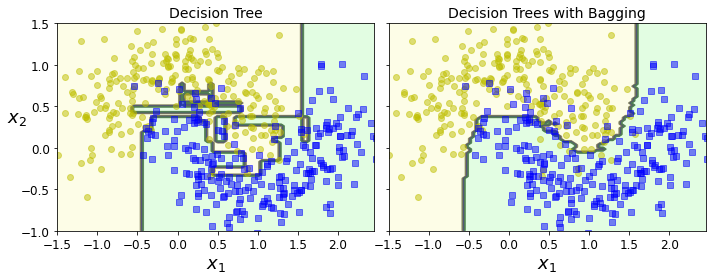

In [12]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

This plot compares the decision boundary of a single decision tree with the decision boundary of a bagging ensemble of 500 trees. 
* The ensemble's predictions will likely generalize much better than the single DecisionTree's predictions. 
* The ensemble has a comparable bias but a smaller variance (the decision boundary is less irregular).

The boostrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, with a lower variance.

Bagging often results in better models. If you have spare time and CPU power, you can use cross validation to evaluate both bagging and pasting and select the one that works best.

## Out-of-Bag evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all.

By default a BaggingClassifier samples m training instances with replacement, where m is the size of the training set. Only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances (not sampled) are called `out-of-bag (oob)` instances. They are not the same 37% for all predictors.

A predictor does not see out-of-bag instances, so it can be evaluated on these instances without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the out-of-bag evaluations of each predictor.

To do so, you can set `oob_score=True` when creating a BaggingClassifier to request an automatic oob evaluation after training.

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

The resulting evaluation score is available through the `oob_score_` variable. This classifier is likely to achieve about 89.8%. 

The oob decision function for each training instance is also available through the `oob_decision_function_` variable. The function returns the class probabilities for each training instance. The oob evaluation estimates that the first training instance has a 67.72% probability of belonging to the positive class and 32.27% of belonging to the negative class.

In [14]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [15]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# Random Forests

A Random Forest is an `ensemble of decision trees`, generally trained via the bagging method or pasting method, by using `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the `RandomForestClassifier` class, which is more convenient and optimized for DecisionTree.

There is also a RandomForestRegressor class for regression tasks.

The following code uses all available CPU cores to train a RandomForest classifier with 500 trees, each limited to maximum 16 nodes.

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42, n_jobs=1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

A RandomForestClassifer has all the hyperparameters of a DecisionTreeClassifier, to control how trees are grown, plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

The RandomForest algorithm searches for the best feature among a random subset of features.

A Random Forest is equivalent to a bag of decision trees.

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42, n_jobs=1)

In [18]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [19]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

# Boosting

Boosting refers to any ensemble method that can combine several weak learners into a strong learner. The geneal idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. Adaboost is one of the boosting methods.

# Stacking

Stacking or stacked generalization trains a model to aggregate the predictions of all predictors. The final predictor called blender or a meta learner takes these predictions as inputs and makes the final prediction.